In [601]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import math

from factor_selection import svd

In [602]:
data = pd.read_parquet('cleaned.parquet')

non_factor_cols = {'permno', 'yyyymm', 'monthid', 'ticker', 'conm', 'gvkey', 'cusip', 'naics', 'gsubind', 'PRC', 'RET', 'SHROUT', 'ret_f1', 'ret_f2', 'ret_f3', 'ret_f4', 'ret_f5', 'ret_f6', 'ret_f7', 'ret_f8', 'ret_f9', 'ret_f10', 'ret_f11', 'ret_f12', 'date_x', 'fdate', 'ret', 'date_y', 'date'}
factor_cols = set(data.columns) - non_factor_cols

In [603]:
composite_factors = [
    "mean_reversion_signal", "RD_P", "trend_factor", "Accrual", "range_120", "range_20",
    "xret_indsize_std120", "RD_SALE", "rolling_z_score", "FCF_P", "SIR", "beta_5y", 
    "beta_3y", "SIO", "betasq", "beta", "IV_capm", "xret_indsize_std20", "PM_P", "ivol", 
    "RSI_20", "Sale_P", "FCF", "mdr", "ltr36", "mktcap", "tail_2y", "AbsAccrual", 
    "MoneyFlowIndex_20", "pe_ttm"
]
chosen = composite_factors[:10]

In [604]:
unique_dates = sorted(data['yyyymm'].unique())
training_ratio = 4/5

split_index = int(len(unique_dates) * training_ratio)
split_date = unique_dates[split_index]
print(f"Split at yyyymm: {split_date}")

Split at yyyymm: 201501


### Obtaining Betas From Training

In [605]:
train_data = data[data['yyyymm'] < split_date].copy()

train_data_SVD, S, signal_weights, scaling_info = svd.svd_factor_extraction(data, chosen, n_factors=10)
selected_factors = [col for col  in train_data_SVD.columns if col.startswith('SVD_')]
print(selected_factors)
train_data = pd.concat([train_data, train_data_SVD], axis=1)

# train_factors = train_data[['permno', 'yyyymm'] + selected_factors].copy()
# train_returns = train_data[['permno', 'yyyymm', 'ret_f1']].copy()

# regression_data = pd.merge(train_factors, train_returns, on=['permno', 'yyyymm'], how='inner')
regression_data = train_data[['permno', 'yyyymm', 'ret_f1'] + selected_factors].copy()
stock_groups = regression_data.groupby('permno')
results = []
min_observations = len(selected_factors) + 2 

['SVD_Factor_1', 'SVD_Factor_2', 'SVD_Factor_3', 'SVD_Factor_4', 'SVD_Factor_5', 'SVD_Factor_6', 'SVD_Factor_7', 'SVD_Factor_8', 'SVD_Factor_9', 'SVD_Factor_10']


In [606]:
for permno, group in stock_groups:
    group = group.dropna(subset=['ret_f1'] + selected_factors)
    
    if len(group) >= min_observations:
        Y = group['ret_f1']
        X = group[selected_factors]
        X = sm.add_constant(X)

        try:
            model = sm.OLS(Y, X, missing='drop').fit()
            stock_result = {'permno': permno, 'alpha': model.params.get('const', np.nan)}
            for factor in selected_factors:
                stock_result[f'{factor}_beta'] = model.params.get(factor, np.nan)
            results.append(stock_result)

        except Exception as e:
            print(f"Could not run regression for permno {permno}: {e}")

stock_betas_df = pd.DataFrame(results)

In [607]:
beta_cols = [col for col in stock_betas_df.columns if '_beta' in col]
cols_to_average = ['alpha'] + beta_cols
average_betas_and_alpha = stock_betas_df[cols_to_average].mean()

average_betas_and_alpha_df = pd.DataFrame(average_betas_and_alpha).T
average_betas_and_alpha_df.index = ['average']

In [608]:
print(average_betas_and_alpha_df)

            alpha  SVD_Factor_1_beta  SVD_Factor_2_beta  SVD_Factor_3_beta  \
average  0.293241           0.006244           0.002884           0.017821   

         SVD_Factor_4_beta  SVD_Factor_5_beta  SVD_Factor_6_beta  \
average          -0.001439          -0.003136          -0.004863   

         SVD_Factor_7_beta  SVD_Factor_8_beta  SVD_Factor_9_beta  \
average           0.005037          -0.001206           0.046204   

         SVD_Factor_10_beta  
average            0.000039  


### Backtesting Linear Model
r̃_{i,t+1} = â₀ + b̂₁F1_{i,t} + b̂₂F2_{i,t} + ... + b̂_K Fk_{i,t} for stocks i at t, then calculating decile returns

In [609]:
backtest_data = data[data['yyyymm'] >= split_date].copy()
backtest_data['monthid'] = backtest_data['monthid'] - 420

backtest_data_SVD = svd.apply_svd_factors(backtest_data, chosen, signal_weights, scaling_info, n_factors=10)
backtest_data = pd.concat([backtest_data, backtest_data_SVD], axis=1)

In [610]:
avg_alpha = average_betas_and_alpha_df['alpha']['average']
avg_betas = average_betas_and_alpha_df[[col for col in average_betas_and_alpha_df.columns if '_beta' in col]].iloc[0]
avg_betas.index = [col.replace('_beta', '') for col in avg_betas.index]

factors_for_prediction = [factor for factor in selected_factors if factor in backtest_data.columns]
backtest_data['predicted_ret'] = avg_alpha

for factor in factors_for_prediction:
    if factor in avg_betas:
        backtest_data['predicted_ret'] += backtest_data[factor] * avg_betas[factor]

In [611]:
portfolio_returns = []
monthly_groups = backtest_data.groupby('yyyymm')

for month, group in monthly_groups:
    group = group.dropna(subset=['predicted_ret', 'ret_f1'])

    if len(group) < 10:
        continue
    try:
        group_copy = group.copy()
        group_copy.loc[:, 'decile'] = pd.qcut(group_copy['predicted_ret'], 10, labels=False, duplicates='drop') + 1
        group = group_copy 
    except ValueError as e:
        print(f"Could not form deciles for month {month} due to: {e}. Skipping.")
        continue

    if 1 not in group['decile'].values or 10 not in group['decile'].values:
        continue

    long_portfolio_ret = group[group['decile'] == 10]['ret_f1'].mean()
    short_portfolio_ret = group[group['decile'] == 1]['ret_f1'].mean()

    long_stocks = group[group['decile'] == 10]['permno'].unique()
    short_stocks = group[group['decile'] == 1]['permno'].unique()

    if pd.isna(long_portfolio_ret) or pd.isna(short_portfolio_ret):
        continue

    hedge_return = long_portfolio_ret - short_portfolio_ret
    portfolio_returns.append(
        {'yyyymm': month, 
         'hedge_return': hedge_return, 
         'long_stocks': long_stocks, 
         'short_stocks': short_stocks}
    )

hedge_portfolio_df = pd.DataFrame(portfolio_returns)
hedge_portfolio_df['yyyymm'] = pd.to_datetime(hedge_portfolio_df['yyyymm'], format='%Y%m')
hedge_portfolio_df = hedge_portfolio_df.set_index('yyyymm')
# avoid lookahead bias by shifting the index by one month
# make first month returns 0
hedge_portfolio_df['hedge_return'] = hedge_portfolio_df['hedge_return'].shift(1)
hedge_portfolio_df.loc[hedge_portfolio_df.index[0], 'hedge_return'] = 0.0

In [612]:
number_of_stocks = hedge_portfolio_df['long_stocks'].apply(len) + hedge_portfolio_df['short_stocks'].apply(len)
average_number_of_stocks = number_of_stocks.mean()
print(f"Average number of stocks in hedge portfolio: {average_number_of_stocks:.2f}")

Average number of stocks in hedge portfolio: 56.00


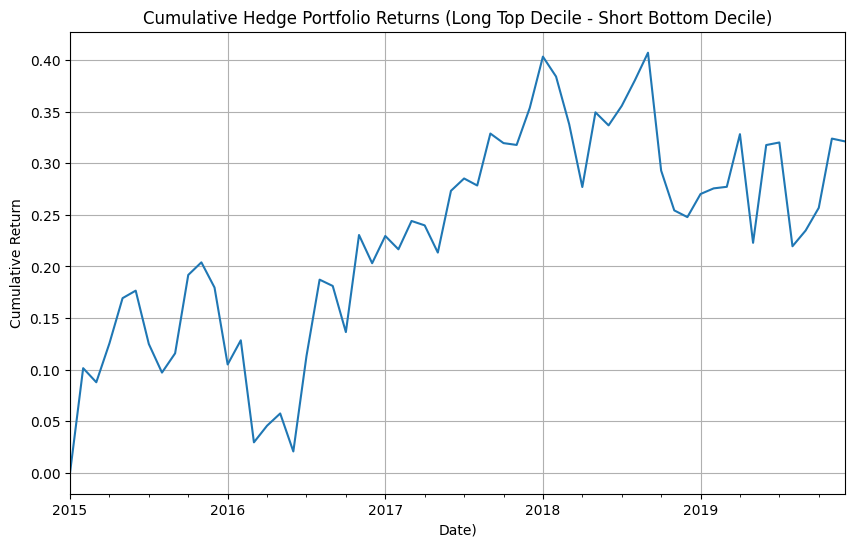

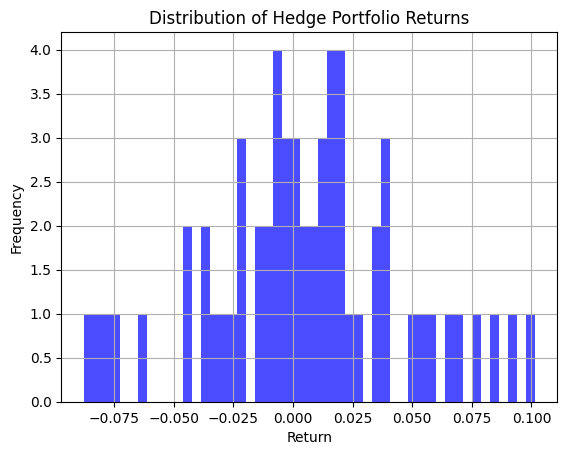

In [613]:
hedge_portfolio_df['cumulative_return'] = (1 + hedge_portfolio_df['hedge_return']).cumprod() - 1
plt.figure(figsize=(10, 6))
hedge_portfolio_df['cumulative_return'].plot(title='Cumulative Hedge Portfolio Returns (Long Top Decile - Short Bottom Decile)')
plt.xlabel('Date)')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

hedge_portfolio_df['hedge_return'].hist(bins=50, alpha=0.7, color='blue')
plt.title('Distribution of Hedge Portfolio Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Analysis 
(1) Raw return 
(2)Sharpe ratio
(3) CAPM alpha
(4) Fama-French 3-Factor alpha
(5) Information Ratio
using 3-factor model

In [614]:
ff_factors = pd.read_sas('ff_factors_monthly.sas7bdat')
ff_factors['monthid'] = ff_factors['DATEFF'].dt.strftime('%Y%m').astype(int)
ff_factors.set_index('monthid', inplace=True)

In [615]:
hedge_portfolio_df_copy = hedge_portfolio_df.copy()
hedge_portfolio_df_copy['monthid'] = hedge_portfolio_df_copy.index.strftime('%Y%m').astype(int)

hedge_portfolio_df_copy = pd.merge(hedge_portfolio_df_copy, ff_factors, on='monthid', how='left')
hedge_portfolio_df_copy.set_index('monthid', inplace=True)

# Calculate excess returns
hedge_portfolio_df_copy['excess_return'] = hedge_portfolio_df_copy['hedge_return'] - hedge_portfolio_df_copy['RF']

analytics = {}

analytics['raw_return'] = hedge_portfolio_df_copy['hedge_return'].mean() * 12
analytics['sharpe_ratio'] = (hedge_portfolio_df_copy['excess_return'].mean() * 12) / (hedge_portfolio_df_copy['excess_return'].std() * np.sqrt(12))

# CAPM
X = sm.add_constant(hedge_portfolio_df_copy['MKTRF'])
capm_model = sm.OLS(hedge_portfolio_df_copy['excess_return'], X).fit()
analytics['capm_alpha'] = capm_model.params['const'] * 12

# FF3
X_ff3 = sm.add_constant(hedge_portfolio_df_copy[['MKTRF', 'SMB', 'HML']])
ff3_model = sm.OLS(hedge_portfolio_df_copy['excess_return'], X_ff3).fit()
analytics['ff3_alpha'] = ff3_model.params['const'] * 12

# Information Ratio
hedge_portfolio_df_copy['benchmark_return'] = hedge_portfolio_df_copy['MKTRF'] + hedge_portfolio_df_copy['RF']
analytics['information_ratio'] = ((hedge_portfolio_df_copy['excess_return'] - hedge_portfolio_df_copy['benchmark_return']).mean() * 12) / ((hedge_portfolio_df_copy['excess_return'] - hedge_portfolio_df_copy['benchmark_return']).std() * np.sqrt(12))

print("Analytics:")
for key, value in analytics.items():
    print(f"{key}: {value:.4f}")

Analytics:
raw_return: 0.0659
sharpe_ratio: 0.3903
capm_alpha: -0.0117
ff3_alpha: 0.0069
information_ratio: -0.4701
